In [38]:
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,  OneHotEncoder
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('./data/train.csv')
df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [34]:
test_df = pd.read_csv('./data/test.csv')
test_df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1
3,517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2
4,517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3


# Análise Exploratória

In [21]:
df.shape

(517754, 14)

In [35]:
test_df.shape

(172585, 13)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

In [23]:
df.describe()

,id,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
count,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000
mean,258876.500000,2.491511,0.488719,46.112575,1.187970,0.352377
std,149462.849975,1.120434,0.272563,15.788521,0.895961,0.166417
min,0.000000,1.000000,0.000000,25.000000,0.000000,0.000000
25%,129438.250000,1.000000,0.260000,35.000000,1.000000,0.230000
50%,258876.500000,2.000000,0.510000,45.000000,1.000000,0.340000
75%,388314.750000,3.000000,0.710000,60.000000,2.000000,0.460000
max,517753.000000,4.000000,1.000000,70.000000,7.000000,1.000000


accident_risk             1.000000
curvature                 0.543946
speed_limit               0.430898
num_reported_accidents    0.213891
id                        0.000969
num_lanes                -0.006003
Name: accident_risk, dtype: float64


<Axes: >

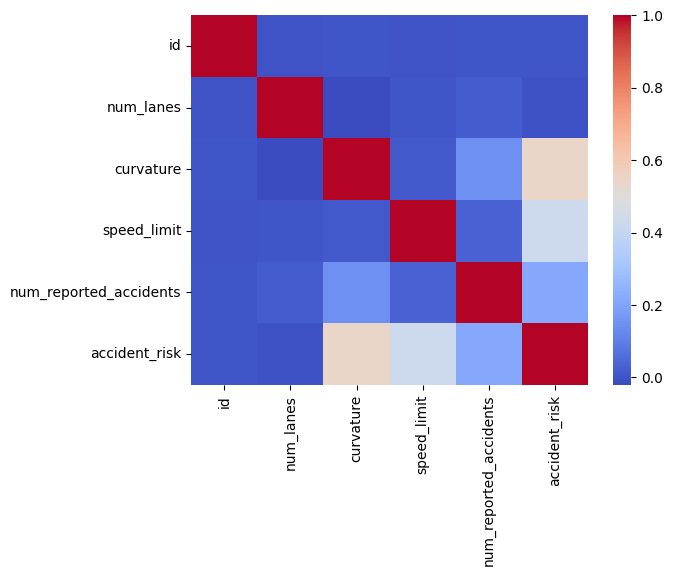

In [24]:
corr = df.select_dtypes(include='number').corr()
corr_target = corr['accident_risk'].sort_values(ascending=False)
print(corr_target)
sns.heatmap(corr, cmap='coolwarm')

In [25]:
df['num_reported_accidents'].value_counts()

num_reported_accidents
1    209674
2    145965
0    125269
3     34197
4      2392
5       231
6        24
7         2
Name: count, dtype: int64

In [26]:
df['accident_risk'].value_counts()

accident_risk
0.34    15542
0.32    14240
0.37    13453
0.28    13287
0.39    12499
        ...  
0.94       47
0.97       28
0.96       28
0.90       26
0.93       23
Name: count, Length: 98, dtype: int64

# Pré-processamento

In [27]:
scaler = MinMaxScaler()
num_features = ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']
df[num_features] = scaler.fit_transform(df[num_features])
df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,0.333333,0.06,0.222222,daylight,rainy,False,True,afternoon,False,True,0.142857,0.13
1,1,urban,1.000000,0.99,0.222222,daylight,clear,True,False,evening,True,True,0.000000,0.35
2,2,rural,1.000000,0.63,1.000000,dim,clear,False,True,morning,True,False,0.285714,0.30
3,3,highway,1.000000,0.07,0.222222,dim,rainy,True,True,morning,False,False,0.142857,0.21
4,4,rural,0.000000,0.58,0.777778,daylight,foggy,False,False,evening,True,False,0.142857,0.56


In [28]:
cat_features = ['road_type', 'lighting', 'weather', 'road_signs_present', 'time_of_day']
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

encoded = enc.fit_transform(df[cat_features])

encoded_df = pd.DataFrame(encoded, columns=enc.get_feature_names_out(cat_features))

df = pd.concat([df.drop(columns=cat_features), encoded_df], axis=1)
df.head()

,id,num_lanes,curvature,speed_limit,public_road,holiday,school_season,num_reported_accidents,accident_risk,road_type_highway,...,lighting_dim,lighting_night,weather_clear,weather_foggy,weather_rainy,road_signs_present_False,road_signs_present_True,time_of_day_afternoon,time_of_day_evening,time_of_day_morning
0,0,0.333333,0.06,0.222222,True,False,True,0.142857,0.13,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,1,1.000000,0.99,0.222222,False,True,True,0.000000,0.35,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,2,1.000000,0.63,1.000000,True,True,False,0.285714,0.30,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,3,1.000000,0.07,0.222222,True,False,False,0.142857,0.21,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,4,0.000000,0.58,0.777778,False,True,False,0.142857,0.56,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)
df.head()

,id,num_lanes,curvature,speed_limit,public_road,holiday,school_season,num_reported_accidents,accident_risk,road_type_highway,...,lighting_dim,lighting_night,weather_clear,weather_foggy,weather_rainy,road_signs_present_False,road_signs_present_True,time_of_day_afternoon,time_of_day_evening,time_of_day_morning
0,0,0.333333,0.06,0.222222,1,0,1,0.142857,0.13,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,1,1.000000,0.99,0.222222,0,1,1,0.000000,0.35,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,2,1.000000,0.63,1.000000,1,1,0,0.285714,0.30,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,3,1.000000,0.07,0.222222,1,0,0,0.142857,0.21,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,4,0.000000,0.58,0.777778,0,1,0,0.142857,0.56,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


# MLP

In [ ]:
Y = df['accident_risk']
X = df.drop(columns=['accident_risk', 'id'])
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15, random_state=42)

((517754, 21), (517754,))

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
mlp = MLP(input_dim=X_train.shape[1])

loss_function = nn.BCELoss()
optimizer = torch.optim.SGD(mlp.parameters(), lr=0.01, momentum=0.9)

In [ ]:
for epoch in range(500):
    